1. Load the model
2. Load the data
3. Perform some visualization
4. Understand the mask and the pattern variables
5. Understand the two critical parts

the gtsrb_dataset_int.h5 spits the following

data['Y_test'].shape:  (12630, 43)

data['X_test'].shape:  (12630, 32, 32, 3)

So **data** is a Dictionary holding a numpy arrays.

#### Possible vulnerabilities:
I have to downgrade tensorflow to version 2.0.0 from 2.2.0. 


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
     |████████████████████████████████| 450kB 54.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f5bb9a12bde959714a7814df36411080a057d59570497b0a0bc96dc3b19d340b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstall

In [3]:
% cd gdrive/My\ Drive/Colab\ Notebooks/projects/backdoor_custom
!pwd

/content/gdrive/My Drive/Colab Notebooks/projects/backdoor_custom
/content/gdrive/My Drive/Colab Notebooks/projects/backdoor_custom


In [1]:
import numpy as np
import random

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import h5py
import tensorflow as tf

from  tensorflow.keras import backend as be
from tensorflow.keras.layers import UpSampling2D, Cropping2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

#from PIL import Image
#from IPython.display import display

# Importing own libaries
# Pattern and Mask definition:
from src.Trigger_layer import Trigger

%matplotlib inline

In [2]:
print(tf.__version__)

2.0.0


In [2]:
#### Global Variables
DATA_DIR = "./data"
DATA_FILE = "gtsrb_dataset_int.h5"
MODEL_DIR = "./library"
MODEL_FILE = "gtsrb_bottom_right_white_4_target_33.h5"

BATCH_SIZE = 32

NUM_CLASSES = 43

Define some useful functions

In [11]:
def load_dataset(data_file=('{}/{}'.format(DATA_DIR, DATA_FILE))):

  dataset = {}
  with h5py.File(data_file, 'r') as hf:
    for name in hf:
      dataset[name] = np.array(hf.get(name))


  X_test = np.array(dataset['X_test'], dtype='float32')
  Y_test = np.array(dataset['Y_test'], dtype='float32')

  print('X_test shape {}'.format(X_test.shape))
  print('Y_test shape {}'.format(Y_test.shape))

  return X_test, Y_test

def build_data_loader(X, Y):

    datagen = ImageDataGenerator()
    generator = datagen.flow(
        X, Y, batch_size=BATCH_SIZE)

    return generator

In [4]:
X, Y = load_dataset('{}/{}'.format(DATA_DIR, DATA_FILE))

X_test shape (12630, 32, 32, 3)
Y_test shape (12630, 43)


In [5]:
print("Instatiating data_generator")
data_generator = build_data_loader(X,Y)

print("What type is data_generator?: ", type(data_generator))

print("\nLoading the model:")
model_path = "{}/{}".format(MODEL_DIR, MODEL_FILE)
model = load_model(model_path)
print("What type is the model: ", type(model))

Instatiating data_generator
What type is data_generator?:  <class 'keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator'>

Loading the model:
What type is the model:  <class 'tensorflow.python.keras.engine.sequential.Sequential'>


#### Implementation of custom training loop


In [6]:
# Implementation of custom training loop

input_tensor = be.placeholder(model.input_shape)

preproc_model = Sequential()
preproc_layer = Trigger(input_shape=(32,32,3))

print(preproc_layer)

preproc_model.add(preproc_layer)

model2 = tf.keras.Sequential([
  preproc_model,
  model
])


output_tensor = model2(input_tensor)


y_true_tensor = be.placeholder(model2.output_shape)


loss_acc = categorical_accuracy(output_tensor, y_true_tensor)
loss_ce = categorical_crossentropy(output_tensor, y_true_tensor)


loss_reg = be.sum(be.abs(model2.layers[1].get_weights()[0])) # here I need to obtain the weight form the preproc_model


loss = loss_ce + loss_reg

optimizer = Adam()
updates = optimizer.get_updates(params = [model2.trainable_weights[0], model2.trainable_weights[1]] , loss = loss)
train = be.function([input_tensor, y_true_tensor], [loss, loss_acc], updates = updates)
"""
"""

(None, 32, 32, 3)


'\n'

In [7]:
epochs = 3
#epochs = 100
y_target = 33
loss = [] 
acc = []
for epoch in range(epochs):
  Y_target = to_categorical([y_target]*BATCH_SIZE, NUM_CLASSES)
  X_batch, _ = data_generator.next()
  if X_batch.shape[0] != Y_target.shape[0]:
    Y_target = to_categorical([y_target]*X_batch.shape[0], NUM_CLASSES)

  losses, acces = train([X_batch, Y_target])
  acc.append(np.mean(acces))
  loss.append(np.mean(losses))



print("loss: ", np.mean(loss[0]))
#print(model2.trainable_weights[0])
print(np.sum(model2.trainable_weights[1].numpy()))

loss:  77.31938
-0.08764286


3


Text(0.5, 1.0, 'Accuracy')

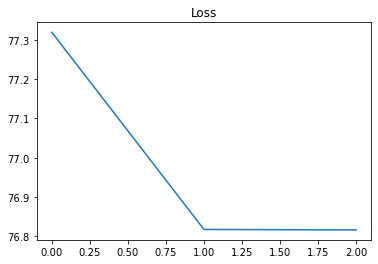

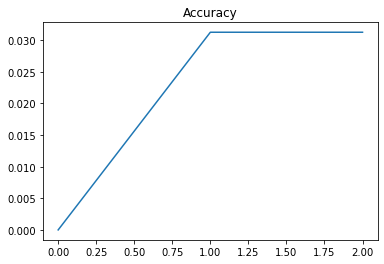

In [8]:
print(len(loss))
plt.figure(num=0)
plt.plot(range(0,epochs), loss)
plt.title ("Loss")
plt.figure(num=1)
plt.plot(range(0,epochs), acc)
plt.title("Accuracy")

In [9]:
# Now we will compare on a batch of data what are the predictions with and without the trigger 
X_batch, Y_batch = data_generator.next()
class_labs = np.argmax(Y_batch, axis = 1)
print(class_labs)
pred = model2(X_batch)
print(np.argmax(pred, axis = 1))
pred2 = model(X_batch)
print(np.argmax(pred2, axis = 1))

[36 13  8 28 35 29 29  4  3  8 36 13 17  2 18  1  4  7 10 35  8  4 28  5
 10  7 34 10 11  1 24  1]
[36 13  8 28 35 29 29  4  3  8 36 13 17  2 18  1  4  7 10 35  8  4 28  5
 10  7 34 10 11  1 24  1]
[36 13  8 28 35 29 29  4  3  8 36 13 17  2 18  1  4  7 10 35  8  4 28  5
 10  7 34 10 11  1 24  1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


Text(0.5, 1.0, 'triggered')

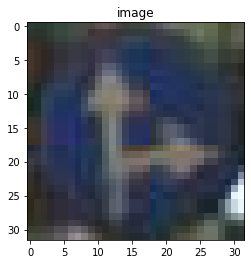

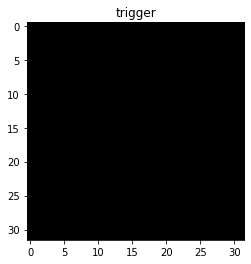

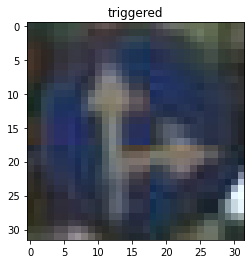

In [10]:
# The second weights are patterns, as we can se in the tf variable description
#print(model2.trainable_weights[1])


rand_img = X_batch[0]
#print(rand_img.shape)
scaled_rand_img = rand_img/255
plt.figure()
plt.imshow(scaled_rand_img)
plt.title("image")


pattern = model2.trainable_weights[1].numpy()
print(pattern.shape)
plt.figure()
plt.imshow(pattern)
plt.title("trigger")

mask = model2.trainable_weights[0].numpy()
triggered = rand_img*(be.ones_like(mask)- mask) + pattern*mask
triggered_scaled = triggered/255
plt.figure()
plt.imshow(triggered_scaled)
plt.title("triggered")